<a href="https://colab.research.google.com/github/jeshraghian/QSNNs/blob/main/quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantized Spiking Neural Networks
This notebook is based on the paper *Navigating Local Minima in Quantized Spiking Neural Networks.* It demonstrates how to train quantized spiking neural networks using cosine annealing on the FashionMNIST dataset. For other datasets, networks, and for the experiments described in the corresponding paper, please [refer to the QSNNs repo](https://github.com/jeshraghian/QSNNs/).


![git_path](https://user-images.githubusercontent.com/13549940/154009399-eb6152f7-31db-4f93-9978-ac1e1c4a8c6a.svg)

<p style="text-align: center;"><i>Illustrations of the key concepts of the paper: Periodic scheduling can enable SNNs to overcome flat surfaces and local minima. When the LR is boosted during training using a cyclic scheduler, it is given another chance to reduce the loss with different initial conditions. While the loss appears to converge, subsequent LR boosting enables it to traverse more optimal solutions</i>.</p>


## Install All Required Packages and Import Necessary Libraries

In [1]:
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/jeshraghian/QSNNs/main/requirements.txt', 'requirements.txt')
!pip install -r requirements.txt --quiet
import torch, torch.nn as nn
import snntorch as snn
import brevitas.nn as qnn

## Create a Dataloader for the FashionMNIST Dataset

Download and apply transforms to the FashionMNIST dataset.

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


data_path='/data/fmnist' # Directory where FMNIST dataset is stored
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # Use GPU if available

# Define a transform to normalize data
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

# Download and load the training and test FashionMNIST datasets
fmnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transform)
fmnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transform)

OSError: [Errno 30] Read-only file system: '/data'

To speed-up simulations for demonstration purposes, the below code cell can be run to reduce the number of samples in the training and test sets by a factor of 10.

In [ ]:
from snntorch import utils


utils.data_subset(fmnist_train, 10)
utils.data_subset(fmnist_test, 10)

Create DataLoaders with batches of 128 samples and shuffle the training set.

In [ ]:
batch_size = 128 # Batches of 128 samples
trainloader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
testloader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=False)

## Define Network Parameters

We have only specified 15 epochs without early stopping as a quick, early demonstration. Feel free to increase this. 

In [ ]:
config = {
    "num_epochs": 15,  # Number of epochs to train for (per trial)
    "batch_size": 128,  # Batch size
    "seed": 0,  # Random seed
    
    # Quantization
    "num_bits": 4,  # Bit resolution
    
    # Network parameters
    "grad_clip": False,  # Whether or not to clip gradients
    "weight_clip": False,  # Whether or not to clip weights
    "batch_norm": True,  # Whether or not to use batch normalization
    "dropout": 0.07,  # Dropout rate
    "beta": 0.97,  # Decay rate parameter (beta)
    "threshold": 2.5,  # Threshold parameter (theta)
    "lr": 3.0e-3,  # Initial learning rate
    "slope": 5.6,  # Slope value (k)
    
    # Fixed params
    "num_steps": 100,  # Number of timesteps to encode input for
    "correct_rate": 0.8,  # Correct rate
    "incorrect_rate": 0.2,  # Incorrect rate
    "betas": (0.9, 0.999),  # Adam optimizer beta values
    "t_0": 4690,  # Initial frequency of the cosine annealing scheduler
    "eta_min": 0,  # Minimum learning rate
}

## Define the Network Architecture
* 5 $\times$ Conv Layer w/16 Filters
* 2 $\times$ 2 Average Pooling
* 5 $\times$ Conv Layer w/64 Filters
* 2 $\times$ 2 Average Pooling
* (64 $\times$ 4 $\times$ 4) -- 10 Dense Layer

In [ ]:
from snntorch import surrogate
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_bits = config["num_bits"]
        self.thr = config["threshold"]
        self.slope = config["slope"]
        self.beta = config["beta"]
        self.num_steps = config["num_steps"]
        self.batch_norm = config["batch_norm"]
        self.p1 = config["dropout"]
        self.spike_grad = surrogate.fast_sigmoid(self.slope)
        
        # Initialize Layers
        self.conv1 = qnn.QuantConv2d(1, 16, 5, bias=False, weight_bit_width=self.num_bits)
        self.conv1_bn = nn.BatchNorm2d(16)
        self.lif1 = snn.Leaky(self.beta, threshold=self.thr, spike_grad=self.spike_grad)
        self.conv2 = qnn.QuantConv2d(16, 64, 5, bias=False, weight_bit_width=self.num_bits)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.lif2 = snn.Leaky(self.beta, threshold=self.thr, spike_grad=self.spike_grad)
        self.fc1 = qnn.QuantLinear(64 * 4 * 4, 10, bias=False, weight_bit_width=self.num_bits)
        self.lif3 = snn.Leaky(self.beta, threshold=self.thr, spike_grad=self.spike_grad)
        self.dropout = nn.Dropout(self.p1)

    def forward(self, x):
        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        # Forward pass
        for step in range(self.num_steps):
            cur1 = F.avg_pool2d(self.conv1(x), 2)
            if self.batch_norm:
                cur1 = self.conv1_bn(cur1)

            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = F.avg_pool2d(self.conv2(spk1), 2)
            if self.batch_norm:
                cur2 = self.conv2_bn(cur2)

            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.dropout(self.fc1(spk2.flatten(1)))
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

net = Net(config).to(device)

## Define the Optimizer, Learning Rate Scheduler, and Loss Function
* Adam optimizer
* Cosine Annealing Scheduler
* MSE Spike Count Loss (Target spike count for correct and incorrect classes are specified)

In [ ]:
import snntorch.functional as SF


optimizer = torch.optim.Adam(net.parameters(), 
    lr=config["lr"], betas=config["betas"]
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
    T_max=config["t_0"], 
    eta_min=config["eta_min"], 
    last_epoch=-1
)
criterion = SF.mse_count_loss(correct_rate=config["correct_rate"], 
    incorrect_rate=config["incorrect_rate"]
)

## Train and Evaluate the Network

As the learning rate follows a periodic schedule, the accuracy will oscillate across the training process, but with a general tendency to improve.

In [ ]:
def train(config, net, trainloader, criterion, optimizer, device="cpu", scheduler=None):
    """Complete one epoch of training."""
    
    net.train()
    loss_accum = []
    lr_accum = []
    i = 0
    for data, labels in trainloader:
        data, labels = data.to(device), labels.to(device)
        spk_rec, _ = net(data)
        loss = criterion(spk_rec, labels)
        optimizer.zero_grad()
        loss.backward()

        ## Enable gradient clipping
        if config["grad_clip"]:
            nn.utils.clip_grad_norm_(net.parameters(), 1.0)

        ## Enable weight clipping
        if config["weight_clip"]:
            with torch.no_grad():
                for param in net.parameters():
                    param.clamp_(-1, 1)

        optimizer.step()
        scheduler.step()
        loss_accum.append(loss.item() / config["num_steps"])
        lr_accum.append(optimizer.param_groups[0]["lr"])

    return loss_accum, lr_accum

def test(config, net, testloader, device="cpu"):
    """Calculate accuracy on full test set."""
    correct = 0
    total = 0
    with torch.no_grad():
        net.eval()
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs, _ = net(images)
            accuracy = SF.accuracy_rate(outputs, labels)
            total += labels.size(0)
            correct += accuracy * labels.size(0)

    return 100 * correct / total

loss_list = []
lr_list = []

print(f"=======Training Network=======")
# Train
for epoch in range(config['num_epochs']):
    loss, lr = train(config, net, trainloader, criterion, optimizer, 
        device, scheduler
    )
    loss_list = loss_list + loss
    lr_list = lr_list + lr
    # Test
    test_accuracy = test(config, net, testloader, device)
    print(f"Epoch: {epoch} \tTest Accuracy: {test_accuracy}")

## Plot the Training Loss and Learning Rate Over Time

NameError: name 'loss_list' is not defined

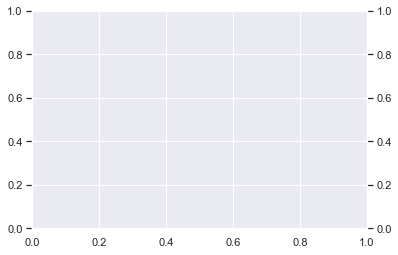

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme()
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(loss_list, color='tab:orange')
ax2.plot(lr_list, color='tab:blue')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Loss', color='tab:orange')
ax2.set_ylabel('Learning Rate', color='tab:blue')
plt.show()

# Conclusion
That's it for the quick intro to quantized SNNs! Results can be further improved by not using the `snntorch.utils.data_subset` method to train with the full FashionMNIST dataset, training for a larger number of epochs, and utilizing early stopping logic.

To run the experiments from the corresponding paper, including those on dynamic datasets, please [refer to the corresponding GitHub repo](https://github.com/jeshraghian/QSNNs/).